In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # To use local CPU instead of local GPU
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image 
import glob
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from pathlib import Path
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from skimage import exposure
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'anno',
 'Assignment2.ipynb',
 'Cropped',
 'Desktop',
 'DM1_ProgrammingAssignment1-Fall2024_712178661.pdf',
 'id_rsa_dond',
 'id_rsa_dond.pub',
 'image',
 'image.zip',
 'stanford-dogs-transfer-crop-stack.html',
 'stanford-dogs-transfer-crop-stack.ipynb',
 'stanford-dogs-transfer-crop-stack.pdf',
 'stanford-dogs-transfer-crop-stack_files',
 'student_8']

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
dog_images = glob.glob('./image/*/*')
breeds = glob.glob('./anno/*')
annotations = glob.glob('./anno/*/*')
cropped = "./Cropped/"
img_size = 299 # For Xception input
train_dir = './Cropped' # './Images'
batch_size_training = 256
batch_size_validation = 256
input_shape = (img_size,img_size,3)



######## Read X and Y coordinate ranges from an annotation ########
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

######## Get image path from annotation path ########
def get_image(annot):
    img_path = './image/'
   
    file = annot.split('\\')
    
    
   
    img_filename = img_path + file[-2] +'/'+file[-1]+'.jpg'
    return img_filename

######## Fill image with black to make a square (not used) ########
def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im


print(len(dog_images), len(breeds), len(annotations))

767 4 767


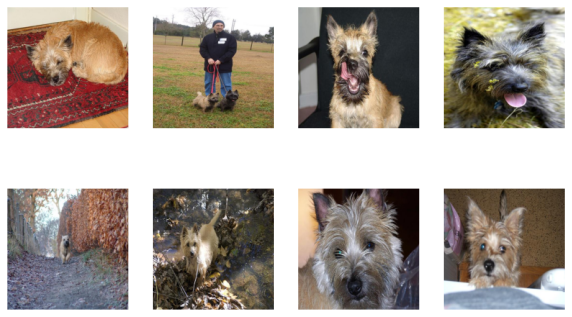

In [4]:
plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    dog = get_image(annotations[i])
    im = Image.open(dog)
    im = im.resize((256,256), Image.Resampling.LANCZOS)
    plt.imshow(im)

In [5]:
plt.figure(figsize=(10,6))
for i in range(len(dog_images)):
    bbox = get_bounding_boxes(annotations[i])
    dog = get_image(annotations[i])
    im = Image.open(dog)
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        im2 = im2.resize((128,128), Image.Resampling.LANCZOS)
        new_path = dog.replace('./image/','./Cropped/')
        new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
        im2=im2.convert('RGB')
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im2.save(new_path)

<Figure size 1000x600 with 0 Axes>

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
from skimage.color import rgb2gray


breeds = glob.glob('./Cropped/*')

## Getting all images from each class

def allimages(breeds):

    

    images = {}

    for folder in breeds:
    
        image_files = [f for f in os.listdir(folder)]
    
        images[folder] = image_files
    return images
            

images_files_list = allimages(breeds)     
    
    


# """Calculate the angles between horizontal and vertical operators."""
def pathtoimage(image_path):
    return rgb2gray(np.array(Image.open(image_path).convert('RGB')))



def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)



def compute_edge_histogram(image):
    
    angle_sobel = angle(filters.sobel_h(image),filters.sobel_v(image))
    hist, hist_center = exposure.histogram(angle_sobel, nbins=36)
    return hist

edge_hist_dict = {}

for file_path_name,file_path_list in images_files_list.items():

    
    edge_histograms = []
    for file_path in file_path_list:
        edge_histogram = compute_edge_histogram(pathtoimage(file_path_name+ '\\'+file_path))
        edge_histograms.append(edge_histogram)
    edge_hist_dict[file_path_name] = edge_histograms

        





In [7]:
# Convert the images to edge histograms. (Assignment 1 - These will be the vector representations of the
# images). This will be your dataset for Part 3. (0.25 point)

# images_files_list.keys,


# Assuming edge_hist_dict is already defined, containing histograms for each class
# Initialize lists for training and test sets for each class
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

# Split each class into training and test sets
for class_name, histograms in edge_hist_dict.items():
    # Convert histograms to a numpy array
    histograms_array = np.array(histograms)
    
    # Create class labels for the current class
    labels = np.array([class_name] * len(histograms_array))
    
    # Perform an 80/20 split for this class
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        histograms_array, labels, test_size=0.2, random_state=42
    )
    
    # Store in separate dictionaries
    X_train_dict[class_name] = X_train_class
    X_test_dict[class_name] = X_test_class
    y_train_dict[class_name] = y_train_class
    y_test_dict[class_name] = y_test_class

# Print sizes of the datasets for each class
# for class_name in edge_hist_dict.keys():
#     print(f"Class: {class_name}")
#     print("Training set size:", X_train_dict[class_name].shape)
#     print("Test set size:", X_test_dict[class_name].shape)

# Combine all training data and labels for standardization




# Standardization
scaler = StandardScaler()


for X_train_name,X_train in X_train_dict.items():
    X_train_dict[X_train_name] = scaler.fit_transform(X_train)
    X_test_dict[X_train_name] = scaler.transform(X_test_dict[X_train_name])

    



In [8]:
## References:

# https://scikit-learn.org/1.5/modules/neural_networks_supervised.html

# https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [9]:

### Classifiers 

Classifiers = {
'GausianDB':GaussianNB(),
'Neuarl Network':MLPClassifier(hidden_layer_sizes=(10, 10, 10), random_state=42),
'Random Forest':RandomForestClassifier(random_state=42)

}



6. (Performance Comparison) Perform stratified 5-fold cross-validation on the 4-class classification problem
using the three classification methods (available on canvas) assigned to you. Plot the (3) confusion
matrices for using three approaches (clearly label the classes) on the test set (See Figure 1). (If you use
code from any website, please do proper referencing. You will get 0 point for this assignment without
proper referencing) (3.75 points)

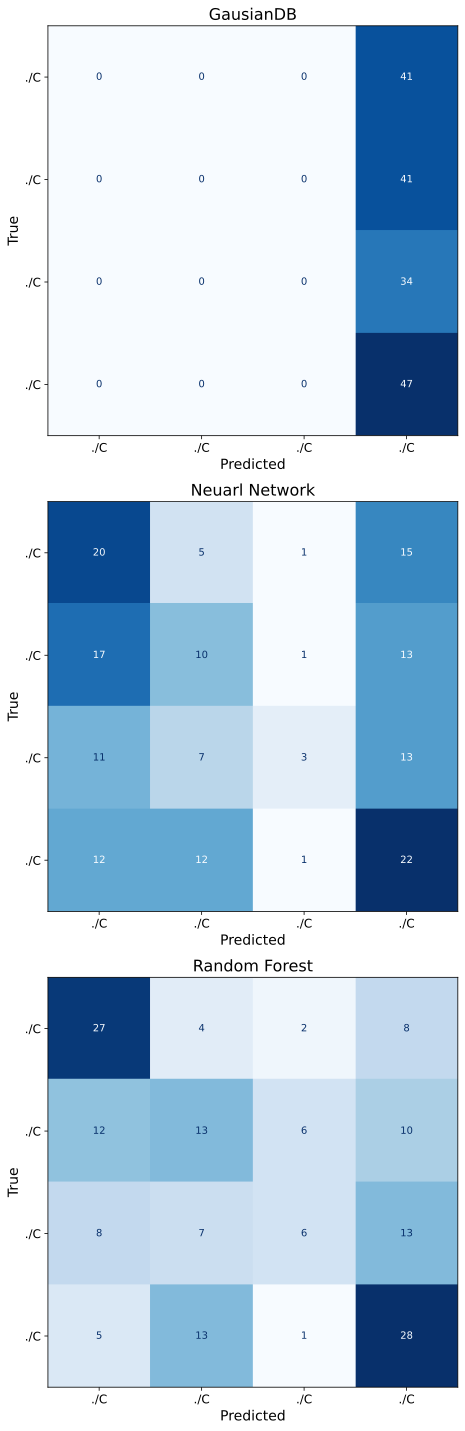

In [10]:

# Assuming edge_hist_dict is already defined, containing histograms for each class
# Combine all training data and labels for standardization
X_test_combined = np.vstack(list(X_test_dict.values()))
y_test_combined = np.hstack(list(y_test_dict.values()))

X_train_combined = np.vstack(list(X_train_dict.values()))
y_train_combined = np.hstack(list(y_train_dict.values()))

# Perform stratified 5-fold cross-validation and collect predictions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
predictions = {}


predictions = {}


for name, clf in Classifiers.items():
    # Train the classifier on the training set
    clf.fit(X_train_combined, y_train_combined)
    
    # Predict on the test set
    preds = clf.predict(X_test_combined)
    predictions[name] = preds

# Plot confusion matrices with increased size
fig, axes = plt.subplots(3, 1, figsize=(18, 20))  # Increase figsize here
for ax, (name, preds) in zip(axes, predictions.items()):
    cm = confusion_matrix(y_test_combined, preds, labels=list(edge_hist_dict.keys()))
    display_labels = [label[:3] for label in edge_hist_dict.keys()]  # Adjust this for 3-character labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    
    # Plot confusion matrix
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    
    # Set titles and other parameters
    ax.set_title(name, fontsize=16)
    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("True", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show() 

In [11]:
from sklearn.model_selection import cross_val_score

mean_accuracies = {}



for name, clf in Classifiers.items():
    scores = cross_val_score(clf, X_train_combined, y_train_combined, cv=cv, scoring='accuracy')
    mean_accuracies[name] = scores.mean()

print("Mean Validation Accuracies:")
for name, mean_accuracy in mean_accuracies.items():
    print(f"{name}: {mean_accuracy:.4f}")


Mean Validation Accuracies:
GausianDB: 0.1502
Neuarl Network: 0.2602
Random Forest: 0.3451


Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods.
Which is the best method? 

Random Forest is best method

In [12]:
test_accuracies = {}

for name, clf in Classifiers.items():
    clf.fit(X_train_combined, y_train_combined)  # Fit on all training data
    test_preds = clf.predict(X_test_combined)  # Use scaled test data
    accuracy = np.mean(test_preds == y_test_combined)  # Calculate accuracy
    test_accuracies[name] = accuracy

print("Test Set Accuracies:")
for name, accuracy in test_accuracies.items():
    print(f"{name}: {accuracy:.4f}")


Test Set Accuracies:
GausianDB: 0.2883
Neuarl Network: 0.3374
Random Forest: 0.4540


Compute the accuracies for the three methods on the test set. Which is the best method? (0.25
point)

Neural Network is best method


In [13]:
from sklearn.metrics import f1_score

f_measures = {}

for name, clf in Classifiers.items():
    clf.fit(X_train_combined, y_train_combined)  # Fit on all training data
    test_preds = clf.predict(X_test_combined)  # Use scaled test data
    f_measure = f1_score(y_test_combined, test_preds, average='weighted')  # Calculate F1 Score
    f_measures[name] = f_measure

print("F-measures on Test Set:")
for name, f_measure in f_measures.items():
    print(f"{name}: {f_measure:.4f}")


F-measures on Test Set:
GausianDB: 0.1291
Neuarl Network: 0.3133
Random Forest: 0.4333


7. (Model Selection) Use images from TWO classes. Perform a standard 5-fold cross-validation and
a stratified 5-fold cross-validation on the training set (i.e., the standardized edge histogram dataset
obtained from the training set) for Support Vector Classifiers using LinearSVC such that parameter
𝐶 = 0.1, 1, 10, 100 and other parameters set as default. (2.5 points)
• Plot a graph (x-axis: 𝐶; y-axis: mean validation/training error (%)) containing four error curves (2
validation error curves and 2 training error curves - label them clearly using a legend to define the
curves). Which 𝐶 has/have the lowest mean error for each curve? Comment about (1) the model
complexity for SVM in relation to 𝐶, and (2) when/whether there is overfitting/underfitting. (1.5
points)
• Use the 𝐶 value with the lowest mean validation error for your SVM classifier from the stratified
5-fold cross-validation. What is the error for the test dataset (i.e., the standardized edge histogram
dataset obtained from the test set)? (0.25 point)

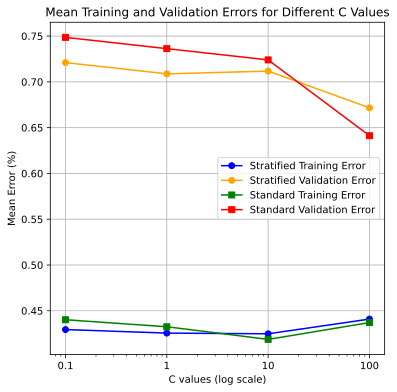

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Assuming X_train_dict, y_train_dict, X_test_dict, and y_test_dict are already defined
# Replace 'Class_A' and 'Class_B' with your actual class labels
names = list(X_train_dict.keys())
selected_classes = [names[0], names[1]]  # Selecting two classes

# Filter the training and testing data for the selected classes
X_train_filtered = np.vstack([X_train_dict[key] for key in X_train_dict if key in selected_classes])
y_train_filtered = np.hstack([y_train_dict[key] for key in y_train_dict if key in selected_classes])

X_test_filtered = np.vstack([X_test_dict[key] for key in X_test_dict if key in selected_classes])
y_test_filtered = np.hstack([y_test_dict[key] for key in y_test_dict if key in selected_classes])

# Values of C to evaluate
C_values = [0.1, 1, 10, 100]
train_errors_stratified = []
val_errors_stratified = []
train_errors_standard = []
val_errors_standard = []

# Stratified 5-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
standard_cv = KFold(n_splits=5, shuffle=True, random_state=42)

for C in C_values:
    svc = LinearSVC(C=C, max_iter=10000)

    # Stratified Cross-Validation for validation error
    stratified_train_errors = []
    stratified_val_errors = []
    
    for train_index, val_index in stratified_cv.split(X_train_filtered, y_train_filtered):
        X_train_split, X_val_split = X_train_filtered[train_index], X_train_filtered[val_index]
        y_train_split, y_val_split = y_train_filtered[train_index], y_train_filtered[val_index]

        # Fit the model
        svc.fit(X_train_split, y_train_split)
        
        # Calculate training error
        train_preds = svc.predict(X_train_split)
        stratified_train_errors.append(1 - accuracy_score(y_train_split, train_preds))
        
        # Calculate validation error
        val_preds = svc.predict(X_val_split)
        stratified_val_errors.append(1 - accuracy_score(y_val_split, val_preds))

    # Store mean errors for stratified
    train_errors_stratified.append(np.mean(stratified_train_errors))
    val_errors_stratified.append(np.mean(stratified_val_errors))

    # Standard Cross-Validation for training and validation error
    standard_train_errors = []
    standard_val_errors = []

    for train_index, test_index in standard_cv.split(X_train_filtered):
        X_train_split, X_test_split = X_train_filtered[train_index], X_train_filtered[test_index]
        y_train_split, y_test_split = y_train_filtered[train_index], y_train_filtered[test_index]

        # Fit the model
        svc.fit(X_train_split, y_train_split)

        # Calculate training error
        train_preds = svc.predict(X_train_split)
        standard_train_errors.append(1 - accuracy_score(y_train_split, train_preds))
        
        # Calculate validation error
        val_preds = svc.predict(X_test_split)
        standard_val_errors.append(1 - accuracy_score(y_test_split, val_preds))

    # Store mean errors for standard
    train_errors_standard.append(np.mean(standard_train_errors))
    val_errors_standard.append(np.mean(standard_val_errors))

# Plotting the errors
plt.figure(figsize=(6, 6))

# Stratified Training and Validation Errors
plt.plot(C_values, train_errors_stratified, label='Stratified Training Error', marker='o', color='blue')
plt.plot(C_values, val_errors_stratified, label='Stratified Validation Error', marker='o', color='orange')

# Standard Training and Validation Errors
plt.plot(C_values, train_errors_standard, label='Standard Training Error', marker='s', color='green')
plt.plot(C_values, val_errors_standard, label='Standard Validation Error', marker='s', color='red')

plt.xscale('log')
plt.xticks(C_values, C_values)
plt.xlabel('C values (log scale)')
plt.ylabel('Mean Error (%)')
plt.title('Mean Training and Validation Errors for Different C Values')
plt.legend()
plt.grid()
plt.show()

# Determine the C with the lowest validation error for both methods





As before, the model complexity can be understood through the relationship between the 
𝐶
C parameter and the resulting errors. Lower values of 
𝐶
C may lead to underfitting, while higher values may lead to overfitting.

The model is  underfitting  as the gap is training and validaition error is high both in standard and stratified

In [15]:
best_C_stratified_index = np.argmin(val_errors_stratified)
best_C_stratified = C_values[best_C_stratified_index]

best_C_standard_index = np.argmin(val_errors_standard)
best_C_standard = C_values[best_C_standard_index]

print(f"Best C value based on stratified validation error: {best_C_stratified}")
print(f"Best C value based on standard validation error: {best_C_standard}")

# Now use the best C value from stratified to compute the error on the test dataset
final_model_stratified = LinearSVC(C=best_C_stratified, max_iter=10000)
final_model_stratified.fit(X_train_filtered, y_train_filtered)
test_preds_stratified = final_model_stratified.predict(X_test_filtered)
test_error_stratified = 1 - accuracy_score(y_test_filtered, test_preds_stratified)

print(f"Test Error for best C value ({best_C_stratified}) from Stratified: {test_error_stratified:.4f}")

# Now use the best C value from standard to compute the error on the test dataset
final_model_standard = LinearSVC(C=best_C_standard, max_iter=10000)
final_model_standard.fit(X_train_filtered, y_train_filtered)
test_preds_standard = final_model_standard.predict(X_test_filtered)
test_error_standard = 1 - accuracy_score(y_test_filtered, test_preds_standard)

print(f"Test Error for best C value ({best_C_standard}) from Standard: {test_error_standard:.4f}")

Best C value based on stratified validation error: 100
Best C value based on standard validation error: 100
Test Error for best C value (100) from Stratified: 0.4878
Test Error for best C value (100) from Standard: 0.4268
